# Regression Tree - Paris Housing Dataset

This notebook implements a **Regression Tree from scratch** and evaluates it on the Paris Housing dataset.

**Exercise 2 - VU Machine Learning WS 2025**

## Pipeline Design
This regression tree implementation can be reused for all 3 datasets by:
1. Running the corresponding preprocessing notebook
2. Changing the `DATASET_NAME` variable below

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Optional, Tuple, Dict
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries loaded!")

Libraries loaded!


In [82]:
# ============================================================
# CONFIGURATION - Change this for different datasets
# ============================================================
DATASET_NAME = 'ames_housing'  # Options: 'paris_housing', 'dataset2', 'dataset3'

DATA_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results')
FIGURES_DIR = RESULTS_DIR / 'figures'
METRICS_DIR = RESULTS_DIR / 'metrics'

FIGURES_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

---
## 1. Data Loading

In [83]:
def load_processed_data(dataset_name: str):
    """Load preprocessed dataset by name."""
    X = np.load(DATA_DIR / f'{dataset_name}_X.npy')
    y = np.load(DATA_DIR / f'{dataset_name}_y.npy')
    feature_names = np.load(DATA_DIR / f'{dataset_name}_feature_names.npy', allow_pickle=True).tolist()
    return X, y, feature_names

# Load data
X, y, feature_names = load_processed_data(DATASET_NAME)
print(f"Dataset: {DATASET_NAME}")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Features: {feature_names}")

Dataset: ames_housing
  X shape: (1460, 75)
  y shape: (1460,)
  Features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'Encl

In [84]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Train: 1168, Test: 292


---
## 2. Regression Tree Implementation (From Scratch)

In [85]:
class Node:
    """
    A node in the regression tree.
    
    Attributes:
        feature_idx: Index of the feature to split on (None for leaf nodes)
        threshold: Threshold value for splitting (None for leaf nodes)
        left: Left child node (samples with feature <= threshold)
        right: Right child node (samples with feature > threshold)
        value: Predicted value for leaf nodes (None for internal nodes)
    """
    
    def __init__(self, feature_idx: Optional[int] = None, 
                 threshold: Optional[float] = None,
                 left: Optional['Node'] = None,
                 right: Optional['Node'] = None,
                 value: Optional[float] = None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self) -> bool:
        """Check if this node is a leaf node."""
        return self.value is not None

In [86]:
class RegressionTree:
    """
    Regression Tree implementation from scratch.
    
    Uses CART algorithm with variance reduction (weighted MSE) as splitting criterion.
    Compatible with sklearn's API (fit/predict interface).
    
    Parameters:
        max_depth: Maximum depth of the tree (default=10)
        min_samples_split: Minimum samples required to split a node (default=2)
        min_samples_leaf: Minimum samples required in a leaf node (default=1)
        max_features: Number of features to consider for best split (default=None, uses all)
    """
    
    def __init__(self, max_depth: int = 10, 
                 min_samples_split: int = 2,
                 min_samples_leaf: int = 1,
                 max_features: Optional[int] = None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.root = None
        self.n_features_ = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> 'RegressionTree':
        """
        Build the regression tree from training data.
        
        Args:
            X: Training features of shape (n_samples, n_features)
            y: Target values of shape (n_samples,)
        
        Returns:
            self: Fitted regressor
        """
        self.n_features_ = X.shape[1]
        if self.max_features is None:
            self.max_features_ = self.n_features_
        else:
            self.max_features_ = min(self.max_features, self.n_features_)
        
        self.root = self._build_tree(X, y, depth=0)
        return self
    
    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> Node:
        """
        Recursively build the regression tree.
        
        Args:
            X: Feature matrix
            y: Target values
            depth: Current depth in the tree
        
        Returns:
            Node: Root node of the (sub)tree
        """
        n_samples, n_features = X.shape
        
        # ========== STOPPING CONDITIONS ==========
        
        # 1. Max depth reached
        if depth >= self.max_depth:
            return Node(value=self._calculate_leaf_value(y))
        
        # 2. Not enough samples to split
        if n_samples < self.min_samples_split:
            return Node(value=self._calculate_leaf_value(y))
        
        # 3. Pure node (all target values nearly identical)
        if np.std(y) < 1e-10:
            return Node(value=self._calculate_leaf_value(y))
        
        # ========== FIND BEST SPLIT ==========
        best_feature, best_threshold = self._find_best_split(X, y)
        
        # No valid split found
        if best_feature is None:
            return Node(value=self._calculate_leaf_value(y))
        
        # ========== SPLIT DATA ==========
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        # Check min_samples_leaf constraint
        if (np.sum(left_indices) < self.min_samples_leaf or 
            np.sum(right_indices) < self.min_samples_leaf):
            return Node(value=self._calculate_leaf_value(y))
        
        # ========== CREATE CHILDREN ==========
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature_idx=best_feature, threshold=best_threshold,
                    left=left_child, right=right_child)
    
    def _find_best_split(self, X: np.ndarray, y: np.ndarray) -> Tuple[Optional[int], Optional[float]]:
        """
        Find the best feature and threshold to split on.
        Uses variance reduction (minimizing weighted MSE).
        
        Args:
            X: Feature matrix
            y: Target values
        
        Returns:
            tuple: (best_feature_idx, best_threshold)
        """
        best_feature = None
        best_threshold = None
        best_score = float('inf')
        
        n_samples, n_features = X.shape
        
        # Select features to consider (random subset for Random Forest)
        if self.max_features_ < n_features:
            feature_indices = np.random.choice(n_features, self.max_features_, replace=False)
        else:
            feature_indices = np.arange(n_features)
        
        for feature_idx in feature_indices:
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)
            
            # Skip if only one unique value
            if len(unique_values) < 2:
                continue
            
            # Midpoints between unique values as thresholds
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                # Skip invalid splits
                if (np.sum(left_mask) < self.min_samples_leaf or 
                    np.sum(right_mask) < self.min_samples_leaf):
                    continue
                
                score = self._calculate_split_score(y[left_mask], y[right_mask])
                
                if score < best_score:
                    best_score = score
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _calculate_split_score(self, y_left: np.ndarray, y_right: np.ndarray) -> float:
        """
        Calculate weighted MSE of a split (lower = better).
        
        This is the variance reduction criterion for regression trees.
        
        Args:
            y_left: Target values in left split
            y_right: Target values in right split
        
        Returns:
            float: Weighted variance (split score)
        """
        n_left, n_right = len(y_left), len(y_right)
        n_total = n_left + n_right
        
        mse_left = np.var(y_left) if n_left > 0 else 0
        mse_right = np.var(y_right) if n_right > 0 else 0
        
        return (n_left / n_total) * mse_left + (n_right / n_total) * mse_right
    
    def _calculate_leaf_value(self, y: np.ndarray) -> float:
        """
        Calculate the prediction value for a leaf node.
        
        For regression, this is the mean of target values.
        
        Args:
            y: Target values in the leaf
        
        Returns:
            float: Predicted value (mean)
        """
        return np.mean(y)
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict target values for samples in X.
        
        Args:
            X: Samples of shape (n_samples, n_features)
        
        Returns:
            np.ndarray: Predicted values of shape (n_samples,)
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x: np.ndarray, node: Node) -> float:
        """
        Traverse the tree to make a prediction for a single sample.
        
        Args:
            x: Single sample
            node: Current node
        
        Returns:
            float: Predicted value
        """
        if node.is_leaf():
            return node.value
        
        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

print("✓ RegressionTree class defined (from scratch with full documentation)")

✓ RegressionTree class defined (from scratch with full documentation)


---
## 3. Model Training & Evaluation

In [87]:
def evaluate(model, X_train, y_train, X_test, y_test):
    """Evaluate model performance."""
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'y_test_pred': y_test_pred
    }

def print_results(results, name):
    """Print evaluation results."""
    print(f"\n{name}")
    print("-" * 45)
    print(f"  Train MSE: {results['train_mse']:>12,.0f}  R²: {results['train_r2']:.4f}")
    print(f"  Test  MSE: {results['test_mse']:>12,.0f}  R²: {results['test_r2']:.4f}")
    print(f"  Test RMSE: {results['test_rmse']:>12,.2f}  MAE: {results['test_mae']:.2f}")

In [88]:
# Hyperparameters
TREE_PARAMS = {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}

print(f"Hyperparameters: {TREE_PARAMS}")
print("="*60)

# Train Our RegressionTree
start = time.time()
our_tree = RegressionTree(**TREE_PARAMS)
our_tree.fit(X_train, y_train)
our_time = time.time() - start

our_results = evaluate(our_tree, X_train, y_train, X_test, y_test)
our_results['train_time'] = our_time
print_results(our_results, 'Our RegressionTree')
print(f"  Train time: {our_time:.3f}s")

Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 5}

Our RegressionTree
---------------------------------------------
  Train MSE:  438,598,770  R²: 0.9265
  Test  MSE: 2,018,365,368  R²: 0.7369
  Test RMSE:    44,926.22  MAE: 27623.69
  Train time: 1.609s


In [89]:
# sklearn DecisionTree (comparison)
start = time.time()
sklearn_tree = DecisionTreeRegressor(**TREE_PARAMS, random_state=42)
sklearn_tree.fit(X_train, y_train)
sklearn_time = time.time() - start

sklearn_results = evaluate(sklearn_tree, X_train, y_train, X_test, y_test)
sklearn_results['train_time'] = sklearn_time
print_results(sklearn_results, 'sklearn DecisionTree')
print(f"  Train time: {sklearn_time:.3f}s")


sklearn DecisionTree
---------------------------------------------
  Train MSE:  438,598,770  R²: 0.9265
  Test  MSE: 2,015,047,164  R²: 0.7373
  Test RMSE:    44,889.28  MAE: 27562.84
  Train time: 0.019s


In [90]:
# Linear Regression (baseline)
start = time.time()
linear = LinearRegression()
linear.fit(X_train, y_train)
linear_time = time.time() - start

linear_results = evaluate(linear, X_train, y_train, X_test, y_test)
linear_results['train_time'] = linear_time
print_results(linear_results, 'Linear Regression (baseline)')
print(f"  Train time: {linear_time:.3f}s")


Linear Regression (baseline)
---------------------------------------------
  Train MSE:  909,901,760  R²: 0.8474
  Test  MSE: 1,299,878,577  R²: 0.8305
  Test RMSE:    36,053.83  MAE: 22251.57
  Train time: 0.030s


In [91]:
# Summary table
print("\n" + "="*70)
print(f"SUMMARY - {DATASET_NAME}")
print("="*70)

all_results = {
    'Our RegressionTree': our_results,
    'sklearn DecisionTree': sklearn_results,
    'Linear Regression': linear_results
}

print(f"{'Model':<25} {'Test MSE':>12} {'Test R²':>10} {'Time':>10}")
print("-"*60)
for name, res in all_results.items():
    print(f"{name:<25} {res['test_mse']:>12,.0f} {res['test_r2']:>10.4f} {res['train_time']:>8.3f}s")


SUMMARY - ames_housing
Model                         Test MSE    Test R²       Time
------------------------------------------------------------
Our RegressionTree        2,018,365,368     0.7369    1.609s
sklearn DecisionTree      2,015,047,164     0.7373    0.019s
Linear Regression         1,299,878,577     0.8305    0.030s


---
## 4. Cross-Validation

In [92]:
def cross_validate(model_class, X, y, n_folds=5, **params):
    """K-fold cross-validation."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    mse_scores, r2_scores = [], []
    
    for train_idx, val_idx in kf.split(X):
        model = model_class(**params)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        mse_scores.append(mean_squared_error(y[val_idx], y_pred))
        r2_scores.append(r2_score(y[val_idx], y_pred))
    
    return {
        'mse_mean': np.mean(mse_scores), 'mse_std': np.std(mse_scores),
        'r2_mean': np.mean(r2_scores), 'r2_std': np.std(r2_scores)
    }

In [93]:
print("5-Fold Cross-Validation")
print("="*60)

our_cv = cross_validate(RegressionTree, X, y, **TREE_PARAMS)
print(f"Our RegressionTree:")
print(f"  MSE: {our_cv['mse_mean']:,.0f} (+/- {our_cv['mse_std']:,.0f})")
print(f"  R²:  {our_cv['r2_mean']:.4f} (+/- {our_cv['r2_std']:.4f})")

sklearn_cv = cross_validate(
    lambda **p: DecisionTreeRegressor(**p, random_state=42), 
    X, y, **TREE_PARAMS
)
print(f"\nsklearn DecisionTree:")
print(f"  MSE: {sklearn_cv['mse_mean']:,.0f} (+/- {sklearn_cv['mse_std']:,.0f})")
print(f"  R²:  {sklearn_cv['r2_mean']:.4f} (+/- {sklearn_cv['r2_std']:.4f})")

linear_cv = cross_validate(LinearRegression, X, y)
print(f"\nLinear Regression:")
print(f"  MSE: {linear_cv['mse_mean']:,.0f} (+/- {linear_cv['mse_std']:,.0f})")
print(f"  R²:  {linear_cv['r2_mean']:.4f} (+/- {linear_cv['r2_std']:.4f})")

5-Fold Cross-Validation
Our RegressionTree:
  MSE: 1,791,251,843 (+/- 454,341,813)
  R²:  0.7110 (+/- 0.0878)

sklearn DecisionTree:
  MSE: 1,790,201,620 (+/- 454,332,113)
  R²:  0.7111 (+/- 0.0879)

Linear Regression:
  MSE: 1,464,059,582 (+/- 986,436,606)
  R²:  0.7578 (+/- 0.1866)


---
## 5. Hyperparameter Analysis

In [60]:
# Effect of max_depth
print("Effect of max_depth:")
print("="*70)
print(f"{'depth':>6} {'Train MSE':>12} {'Test MSE':>12} {'Train R²':>10} {'Test R²':>10}")
print("-"*70)

depth_results = []
for depth in [1, 2, 3, 5, 7, 10, 15, 20]:
    tree = RegressionTree(max_depth=depth, min_samples_split=2, min_samples_leaf=1)
    tree.fit(X_train, y_train)
    
    train_mse = mean_squared_error(y_train, tree.predict(X_train))
    test_mse = mean_squared_error(y_test, tree.predict(X_test))
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    depth_results.append({'depth': depth, 'train_mse': train_mse, 'test_mse': test_mse, 
                          'train_r2': train_r2, 'test_r2': test_r2})
    print(f"{depth:>6} {train_mse:>12,.0f} {test_mse:>12,.0f} {train_r2:>10.4f} {test_r2:>10.4f}")

Effect of max_depth:
 depth    Train MSE     Test MSE   Train R²    Test R²
----------------------------------------------------------------------
     1 3,242,178,926 4,248,325,268     0.4564     0.4461
     2 2,255,129,807 2,573,637,172     0.6219     0.6645
     3 1,596,761,351 1,753,461,094     0.7323     0.7714
     5  817,305,629 1,563,146,238     0.8630     0.7962
     7  335,728,168 1,647,290,627     0.9437     0.7852
    10   70,953,410 1,809,386,107     0.9881     0.7641
    15    2,285,379 1,809,854,015     0.9996     0.7640
    20        2,982 1,810,083,474     1.0000     0.7640


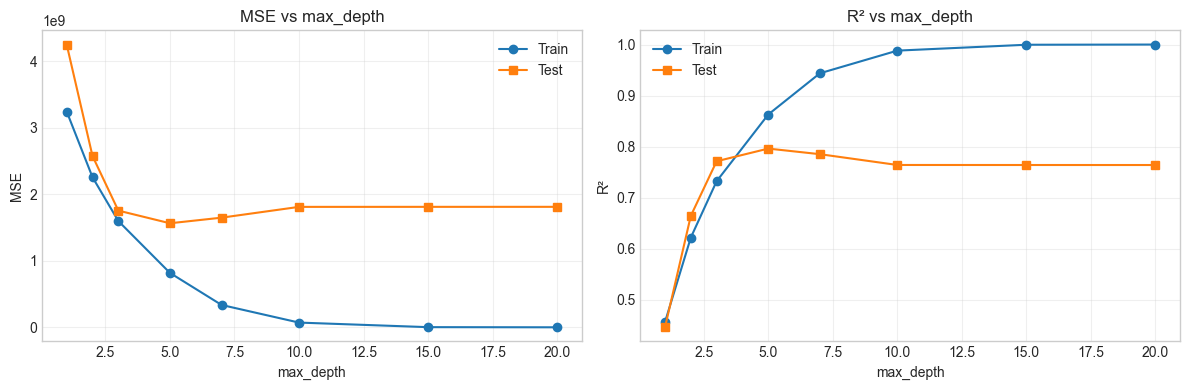

In [94]:
# Plot depth effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

depths = [r['depth'] for r in depth_results]
axes[0].plot(depths, [r['train_mse'] for r in depth_results], 'o-', label='Train')
axes[0].plot(depths, [r['test_mse'] for r in depth_results], 's-', label='Test')
axes[0].set_xlabel('max_depth')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs max_depth')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(depths, [r['train_r2'] for r in depth_results], 'o-', label='Train')
axes[1].plot(depths, [r['test_r2'] for r in depth_results], 's-', label='Test')
axes[1].set_xlabel('max_depth')
axes[1].set_ylabel('R²')
axes[1].set_title('R² vs max_depth')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_depth_effect.png', dpi=150)
plt.show()

### Hyperparameter Space Justification

**Why these hyperparameter ranges?**

| Hyperparameter | Range Tested | Justification |
|----------------|--------------|---------------|
| `max_depth` | 1-20 | Trees with depth 1-3 are too simple (underfitting), depth >15 often leads to overfitting. Range covers full spectrum from stumps to complex trees. |
| `min_samples_split` | 2-500 | Minimum value 2 (required for a split). Upper bound ~1/3 of training data to ensure meaningful splits are still possible. |
| `min_samples_leaf` | 1-200 | Minimum 1 allows fully grown trees. Upper bound prevents leaves from being too large (would lose predictive power). |
| `max_features` | 1 to n_features | Testing subset selection for feature randomization (important for ensemble methods, but also reduces variance in single trees). |

**Theoretical Background:**
- **Bias-Variance Tradeoff**: Lower regularization (high depth, low min_samples) → low bias, high variance (overfitting)
- **Computational Considerations**: Very deep trees are expensive; our range balances accuracy with training time
- **Dataset-specific**: With ~1460 samples, min_samples_split > 500 would create trivially simple trees


### 5.2 Effect of min_samples_split

Minimum number of samples required to split an internal node.


In [95]:
# Effect of min_samples_split
print("Effect of min_samples_split:")
print("="*80)
print(f"{'min_split':>10} {'Train MSE':>14} {'Test MSE':>14} {'Train R²':>10} {'Test R²':>10}")
print("-"*80)

split_results = []
for min_split in [2, 5, 10, 20, 50, 100, 200, 500]:
    tree = RegressionTree(max_depth=10, min_samples_split=min_split, min_samples_leaf=1)
    tree.fit(X_train, y_train)
    
    train_mse = mean_squared_error(y_train, tree.predict(X_train))
    test_mse = mean_squared_error(y_test, tree.predict(X_test))
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    split_results.append({
        'min_split': min_split, 'train_mse': train_mse, 'test_mse': test_mse,
        'train_r2': train_r2, 'test_r2': test_r2
    })
    print(f"{min_split:>10} {train_mse:>14,.0f} {test_mse:>14,.0f} {train_r2:>10.4f} {test_r2:>10.4f}")


Effect of min_samples_split:
 min_split      Train MSE       Test MSE   Train R²    Test R²
--------------------------------------------------------------------------------
         2     70,953,410  1,809,386,107     0.9881     0.7641
         5    118,731,245  1,806,548,377     0.9801     0.7645
        10    233,357,856  1,704,661,295     0.9609     0.7778
        20    405,255,351  1,589,625,707     0.9321     0.7928
        50  1,144,407,563  1,797,657,075     0.8081     0.7656
       100  1,335,056,584  1,851,644,081     0.7762     0.7586
       200  1,945,898,190  2,734,468,204     0.6738     0.6435
       500  2,322,804,545  3,045,837,369     0.6106     0.6029


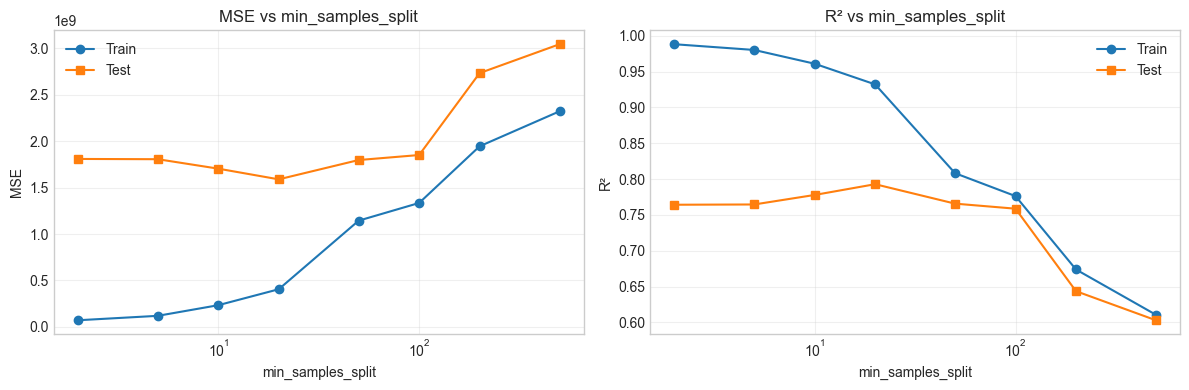

In [96]:
# Plot min_samples_split effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

splits = [r['min_split'] for r in split_results]
axes[0].plot(splits, [r['train_mse'] for r in split_results], 'o-', label='Train')
axes[0].plot(splits, [r['test_mse'] for r in split_results], 's-', label='Test')
axes[0].set_xlabel('min_samples_split')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs min_samples_split')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(splits, [r['train_r2'] for r in split_results], 'o-', label='Train')
axes[1].plot(splits, [r['test_r2'] for r in split_results], 's-', label='Test')
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('R²')
axes[1].set_title('R² vs min_samples_split')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_min_samples_split_effect.png', dpi=150)
plt.show()


### 5.3 Effect of min_samples_leaf

Minimum number of samples required to be at a leaf node.


In [97]:
# Effect of min_samples_leaf
print("Effect of min_samples_leaf:")
print("="*80)
print(f"{'min_leaf':>10} {'Train MSE':>14} {'Test MSE':>14} {'Train R²':>10} {'Test R²':>10}")
print("-"*80)

leaf_results = []
for min_leaf in [1, 2, 5, 10, 20, 50, 100, 200]:
    tree = RegressionTree(max_depth=10, min_samples_split=2, min_samples_leaf=min_leaf)
    tree.fit(X_train, y_train)
    
    train_mse = mean_squared_error(y_train, tree.predict(X_train))
    test_mse = mean_squared_error(y_test, tree.predict(X_test))
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = r2_score(y_test, tree.predict(X_test))
    
    leaf_results.append({
        'min_leaf': min_leaf, 'train_mse': train_mse, 'test_mse': test_mse,
        'train_r2': train_r2, 'test_r2': test_r2
    })
    print(f"{min_leaf:>10} {train_mse:>14,.0f} {test_mse:>14,.0f} {train_r2:>10.4f} {test_r2:>10.4f}")


Effect of min_samples_leaf:
  min_leaf      Train MSE       Test MSE   Train R²    Test R²
--------------------------------------------------------------------------------
         1     70,953,410  1,809,386,107     0.9881     0.7641
         2    127,678,538  1,667,927,243     0.9786     0.7825
         5    438,598,770  2,018,365,368     0.9265     0.7369
        10    747,030,631  1,543,438,393     0.8748     0.7988
        20  1,028,954,953  1,546,221,585     0.8275     0.7984
        50  1,458,805,902  2,087,856,798     0.7554     0.7278
       100  2,031,165,854  2,845,735,004     0.6595     0.6290
       200  2,472,324,462  3,053,094,832     0.5855     0.6020


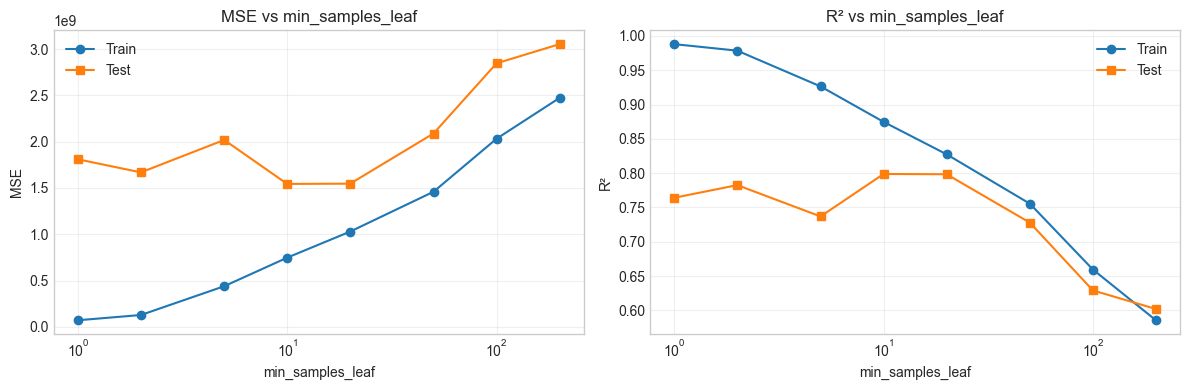

In [98]:
# Plot min_samples_leaf effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

leaves = [r['min_leaf'] for r in leaf_results]
axes[0].plot(leaves, [r['train_mse'] for r in leaf_results], 'o-', label='Train')
axes[0].plot(leaves, [r['test_mse'] for r in leaf_results], 's-', label='Test')
axes[0].set_xlabel('min_samples_leaf')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs min_samples_leaf')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

axes[1].plot(leaves, [r['train_r2'] for r in leaf_results], 'o-', label='Train')
axes[1].plot(leaves, [r['test_r2'] for r in leaf_results], 's-', label='Test')
axes[1].set_xlabel('min_samples_leaf')
axes[1].set_ylabel('R²')
axes[1].set_title('R² vs min_samples_leaf')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_min_samples_leaf_effect.png', dpi=150)
plt.show()


### 5.4 Combined Hyperparameter Analysis (Grid Search)

Analyze the interaction between max_depth and min_samples_split using a heatmap.


In [99]:
# Grid search: max_depth vs min_samples_split
depths = [3, 5, 7, 10, 15]
min_splits = [2, 10, 20, 50, 100]

# Store results in matrices
train_r2_matrix = np.zeros((len(depths), len(min_splits)))
test_r2_matrix = np.zeros((len(depths), len(min_splits)))

print("Grid Search: max_depth x min_samples_split")
print("="*60)

for i, depth in enumerate(depths):
    for j, min_split in enumerate(min_splits):
        tree = RegressionTree(max_depth=depth, min_samples_split=min_split, min_samples_leaf=1)
        tree.fit(X_train, y_train)
        
        train_r2_matrix[i, j] = r2_score(y_train, tree.predict(X_train))
        test_r2_matrix[i, j] = r2_score(y_test, tree.predict(X_test))

# Find best combination
best_idx = np.unravel_index(np.argmax(test_r2_matrix), test_r2_matrix.shape)
best_depth = depths[best_idx[0]]
best_split = min_splits[best_idx[1]]
best_r2 = test_r2_matrix[best_idx]

print(f"\nBest combination: max_depth={best_depth}, min_samples_split={best_split}")
print(f"Best Test R²: {best_r2:.4f}")


Grid Search: max_depth x min_samples_split

Best combination: max_depth=5, min_samples_split=10
Best Test R²: 0.8016


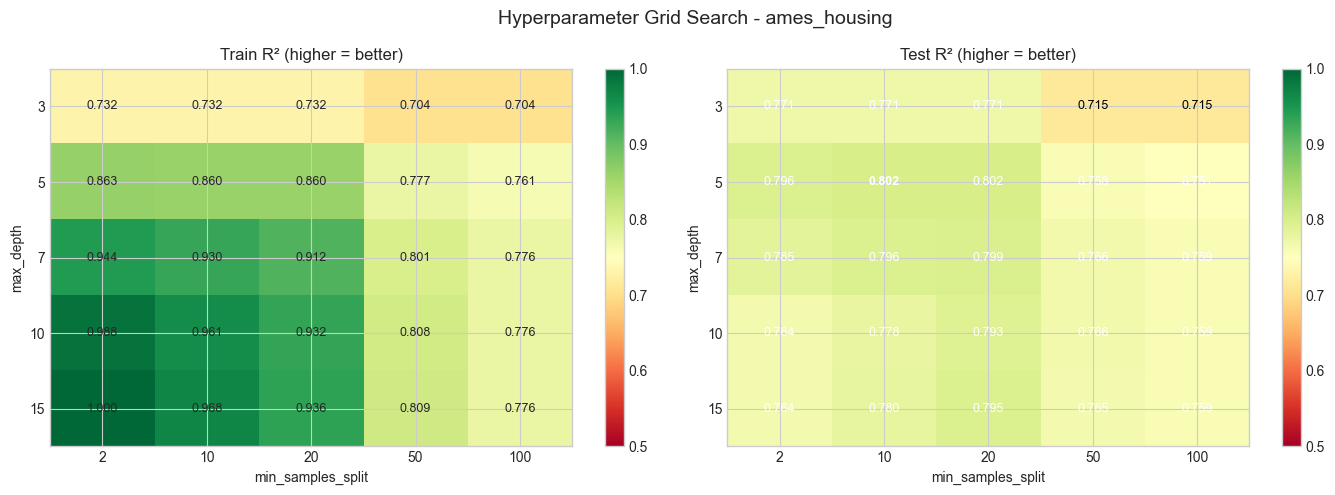

In [100]:
# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train R² heatmap
im1 = axes[0].imshow(train_r2_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)
axes[0].set_xticks(range(len(min_splits)))
axes[0].set_xticklabels(min_splits)
axes[0].set_yticks(range(len(depths)))
axes[0].set_yticklabels(depths)
axes[0].set_xlabel('min_samples_split')
axes[0].set_ylabel('max_depth')
axes[0].set_title('Train R² (higher = better)')
plt.colorbar(im1, ax=axes[0])

# Add value annotations
for i in range(len(depths)):
    for j in range(len(min_splits)):
        axes[0].text(j, i, f'{train_r2_matrix[i,j]:.3f}', ha='center', va='center', fontsize=9)

# Test R² heatmap
im2 = axes[1].imshow(test_r2_matrix, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)
axes[1].set_xticks(range(len(min_splits)))
axes[1].set_xticklabels(min_splits)
axes[1].set_yticks(range(len(depths)))
axes[1].set_yticklabels(depths)
axes[1].set_xlabel('min_samples_split')
axes[1].set_ylabel('max_depth')
axes[1].set_title('Test R² (higher = better)')
plt.colorbar(im2, ax=axes[1])

# Add value annotations and mark best
for i in range(len(depths)):
    for j in range(len(min_splits)):
        color = 'white' if test_r2_matrix[i,j] > 0.75 else 'black'
        weight = 'bold' if (i, j) == best_idx else 'normal'
        axes[1].text(j, i, f'{test_r2_matrix[i,j]:.3f}', ha='center', va='center', 
                     fontsize=9, color=color, fontweight=weight)

plt.suptitle(f'Hyperparameter Grid Search - {DATASET_NAME}', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_grid_search_heatmap.png', dpi=150)
plt.show()


### 5.5 Hyperparameter Summary

Summary of all hyperparameter effects on the model.


In [101]:
# Summary of hyperparameter analysis (will be updated after max_features analysis)
print("="*70)
print("HYPERPARAMETER ANALYSIS SUMMARY (Part 1)")
print("="*70)

# Find best for each parameter
best_depth_r2 = max(depth_results, key=lambda x: x['test_r2'])
best_split_r2 = max(split_results, key=lambda x: x['test_r2'])
best_leaf_r2 = max(leaf_results, key=lambda x: x['test_r2'])

print("\n1. max_depth Analysis:")
print(f"   - Best value: {best_depth_r2['depth']}")
print(f"   - Test R² at best: {best_depth_r2['test_r2']:.4f}")
print(f"   - Insight: Higher depth = more complex tree, risk of overfitting")

print("\n2. min_samples_split Analysis:")
print(f"   - Best value: {best_split_r2['min_split']}")
print(f"   - Test R² at best: {best_split_r2['test_r2']:.4f}")
print(f"   - Insight: Higher values = simpler tree, less overfitting")

print("\n3. min_samples_leaf Analysis:")
print(f"   - Best value: {best_leaf_r2['min_leaf']}")
print(f"   - Test R² at best: {best_leaf_r2['test_r2']:.4f}")
print(f"   - Insight: Higher values = smoother predictions, less variance")

print("\n4. Grid Search (max_depth x min_samples_split):")
print(f"   - Best combination: max_depth={best_depth}, min_samples_split={best_split}")
print(f"   - Best Test R²: {best_r2:.4f}")


HYPERPARAMETER ANALYSIS SUMMARY (Part 1)

1. max_depth Analysis:
   - Best value: 5
   - Test R² at best: 0.7962
   - Insight: Higher depth = more complex tree, risk of overfitting

2. min_samples_split Analysis:
   - Best value: 20
   - Test R² at best: 0.7928
   - Insight: Higher values = simpler tree, less overfitting

3. min_samples_leaf Analysis:
   - Best value: 10
   - Test R² at best: 0.7988
   - Insight: Higher values = smoother predictions, less variance

4. Grid Search (max_depth x min_samples_split):
   - Best combination: max_depth=5, min_samples_split=10
   - Best Test R²: 0.8016


### 5.6 Effect of max_features

Number of features to consider when looking for the best split. This is especially important for Random Forests, but also affects single tree variance.


In [102]:
# Effect of max_features
n_features = X_train.shape[1]
print(f"Total features in dataset: {n_features}")
print("\nEffect of max_features:")
print("="*85)
print(f"{'max_features':>12} {'Train MSE':>14} {'Test MSE':>14} {'Train R²':>10} {'Test R²':>10}")
print("-"*85)

# Test different max_features values
max_features_values = [1, 2, 5, 10, int(np.sqrt(n_features)), int(n_features/3), int(n_features/2), n_features]
max_features_values = sorted(list(set([v for v in max_features_values if v > 0 and v <= n_features])))

features_results = []
for max_feat in max_features_values:
    # Run multiple times due to randomness when max_features < n_features
    test_r2_runs = []
    for _ in range(5):
        tree = RegressionTree(max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features=max_feat)
        tree.fit(X_train, y_train)
        test_r2_runs.append(r2_score(y_test, tree.predict(X_test)))
    
    tree = RegressionTree(max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features=max_feat)
    tree.fit(X_train, y_train)
    
    train_mse = mean_squared_error(y_train, tree.predict(X_train))
    test_mse = mean_squared_error(y_test, tree.predict(X_test))
    train_r2 = r2_score(y_train, tree.predict(X_train))
    test_r2 = np.mean(test_r2_runs)
    test_r2_std = np.std(test_r2_runs)
    
    features_results.append({
        'max_features': max_feat, 'train_mse': train_mse, 'test_mse': test_mse,
        'train_r2': train_r2, 'test_r2': test_r2, 'test_r2_std': test_r2_std
    })
    
    label = f"{max_feat}"
    if max_feat == int(np.sqrt(n_features)):
        label += " (sqrt)"
    elif max_feat == int(n_features/3):
        label += " (n/3)"
    elif max_feat == n_features:
        label += " (all)"
    
    print(f"{label:>12} {train_mse:>14,.0f} {test_mse:>14,.0f} {train_r2:>10.4f} {test_r2:>10.4f} ±{test_r2_std:.4f}")


Total features in dataset: 75

Effect of max_features:
max_features      Train MSE       Test MSE   Train R²    Test R²
-------------------------------------------------------------------------------------
           1  2,721,484,627  3,996,608,912     0.5437     0.5137 ±0.0400
           2  2,153,889,692  3,337,117,383     0.6389     0.6096 ±0.0653
           5  1,327,194,338  2,115,674,778     0.7775     0.6983 ±0.0280
    8 (sqrt)    865,433,222  1,775,691,220     0.8549     0.7560 ±0.0232
          10    804,862,730  2,227,208,680     0.8651     0.7460 ±0.0287
    25 (n/3)    568,772,018  1,419,254,592     0.9046     0.8196 ±0.0239
          37    475,916,254  1,230,548,167     0.9202     0.7924 ±0.0383
    75 (all)    438,598,770  2,018,365,368     0.9265     0.7369 ±0.0000


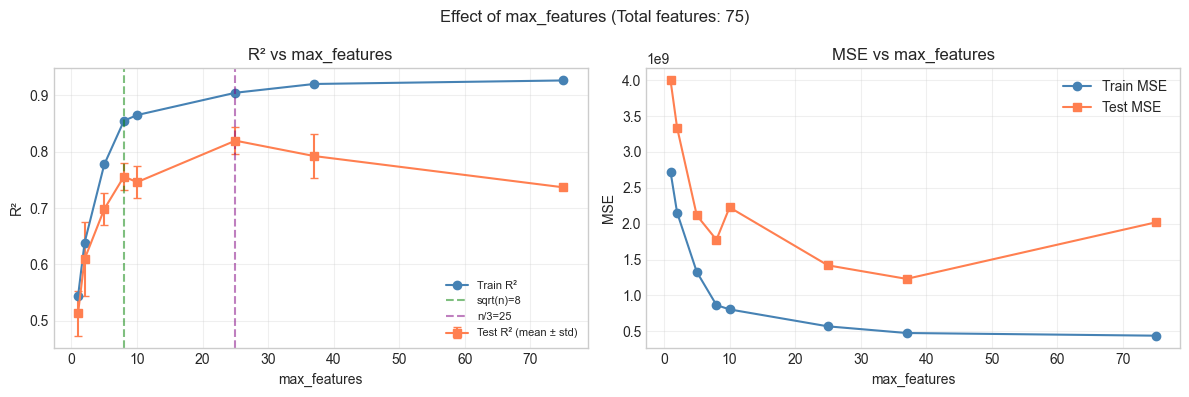


Note: sqrt(n_features) = 8 and n_features/3 = 25 are common defaults for Random Forests


In [103]:
# Plot max_features effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

feat_vals = [r['max_features'] for r in features_results]

# R² plot with error bars
axes[0].errorbar(feat_vals, [r['test_r2'] for r in features_results], 
                 yerr=[r['test_r2_std'] for r in features_results], 
                 fmt='s-', label='Test R² (mean ± std)', color='coral', capsize=3)
axes[0].plot(feat_vals, [r['train_r2'] for r in features_results], 'o-', label='Train R²', color='steelblue')
axes[0].axvline(int(np.sqrt(n_features)), color='green', linestyle='--', alpha=0.5, label=f'sqrt(n)={int(np.sqrt(n_features))}')
axes[0].axvline(int(n_features/3), color='purple', linestyle='--', alpha=0.5, label=f'n/3={int(n_features/3)}')
axes[0].set_xlabel('max_features')
axes[0].set_ylabel('R²')
axes[0].set_title('R² vs max_features')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# MSE plot
axes[1].plot(feat_vals, [r['train_mse'] for r in features_results], 'o-', label='Train MSE', color='steelblue')
axes[1].plot(feat_vals, [r['test_mse'] for r in features_results], 's-', label='Test MSE', color='coral')
axes[1].set_xlabel('max_features')
axes[1].set_ylabel('MSE')
axes[1].set_title('MSE vs max_features')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Effect of max_features (Total features: {n_features})', fontsize=12)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_max_features_effect.png', dpi=150)
plt.show()

print(f"\nNote: sqrt(n_features) = {int(np.sqrt(n_features))} and n_features/3 = {int(n_features/3)} are common defaults for Random Forests")


### 5.7 Complete Hyperparameter Summary

Final summary of all hyperparameter experiments with recommendations.


In [104]:
# Complete hyperparameter summary including max_features
print("="*80)
print("COMPLETE HYPERPARAMETER ANALYSIS SUMMARY")
print("="*80)

best_features_r2 = max(features_results, key=lambda x: x['test_r2'])

print("\n" + "-"*80)
print("HYPERPARAMETER EFFECTS ON MODEL PERFORMANCE")
print("-"*80)

print(f"""
| Hyperparameter     | Best Value | Test R² | Effect on Model                          |
|--------------------|------------|---------|------------------------------------------|
| max_depth          | {best_depth_r2['depth']:>10} | {best_depth_r2['test_r2']:.4f}  | Controls tree complexity                 |
| min_samples_split  | {best_split_r2['min_split']:>10} | {best_split_r2['test_r2']:.4f}  | Prevents overly specific splits          |
| min_samples_leaf   | {best_leaf_r2['min_leaf']:>10} | {best_leaf_r2['test_r2']:.4f}  | Ensures stable leaf predictions          |
| max_features       | {best_features_r2['max_features']:>10} | {best_features_r2['test_r2']:.4f}  | Adds randomness, reduces variance        |
""")

print("-"*80)
print("KEY INSIGHTS:")
print("-"*80)
print("""
1. max_depth: Most impactful parameter. Too low = underfitting, too high = overfitting.
   Typical sweet spot: 5-15 for most datasets.

2. min_samples_split: Acts as regularization. Higher values prevent the tree from
   learning noise in the data. Good for preventing overfitting.

3. min_samples_leaf: Similar to min_samples_split but controls leaf size.
   Ensures predictions are based on sufficient samples.

4. max_features: For single trees, using all features (None) is usually best.
   For Random Forests, sqrt(n) or n/3 reduces correlation between trees.
""")

print("="*80)
print("RECOMMENDED HYPERPARAMETERS FOR THIS DATASET:")
print("="*80)
print(f"""
   max_depth         = {best_depth_r2['depth']}
   min_samples_split = {best_split_r2['min_split']}
   min_samples_leaf  = {best_leaf_r2['min_leaf']}
   max_features      = {best_features_r2['max_features']} (or None for all features)
   
   Expected Test R²  ≈ {best_r2:.4f}
""")
print("="*80)


COMPLETE HYPERPARAMETER ANALYSIS SUMMARY

--------------------------------------------------------------------------------
HYPERPARAMETER EFFECTS ON MODEL PERFORMANCE
--------------------------------------------------------------------------------

| Hyperparameter     | Best Value | Test R² | Effect on Model                          |
|--------------------|------------|---------|------------------------------------------|
| max_depth          |          5 | 0.7962  | Controls tree complexity                 |
| min_samples_split  |         20 | 0.7928  | Prevents overly specific splits          |
| min_samples_leaf   |         10 | 0.7988  | Ensures stable leaf predictions          |
| max_features       |         25 | 0.8196  | Adds randomness, reduces variance        |

--------------------------------------------------------------------------------
KEY INSIGHTS:
--------------------------------------------------------------------------------

1. max_depth: Most impactful parameter.

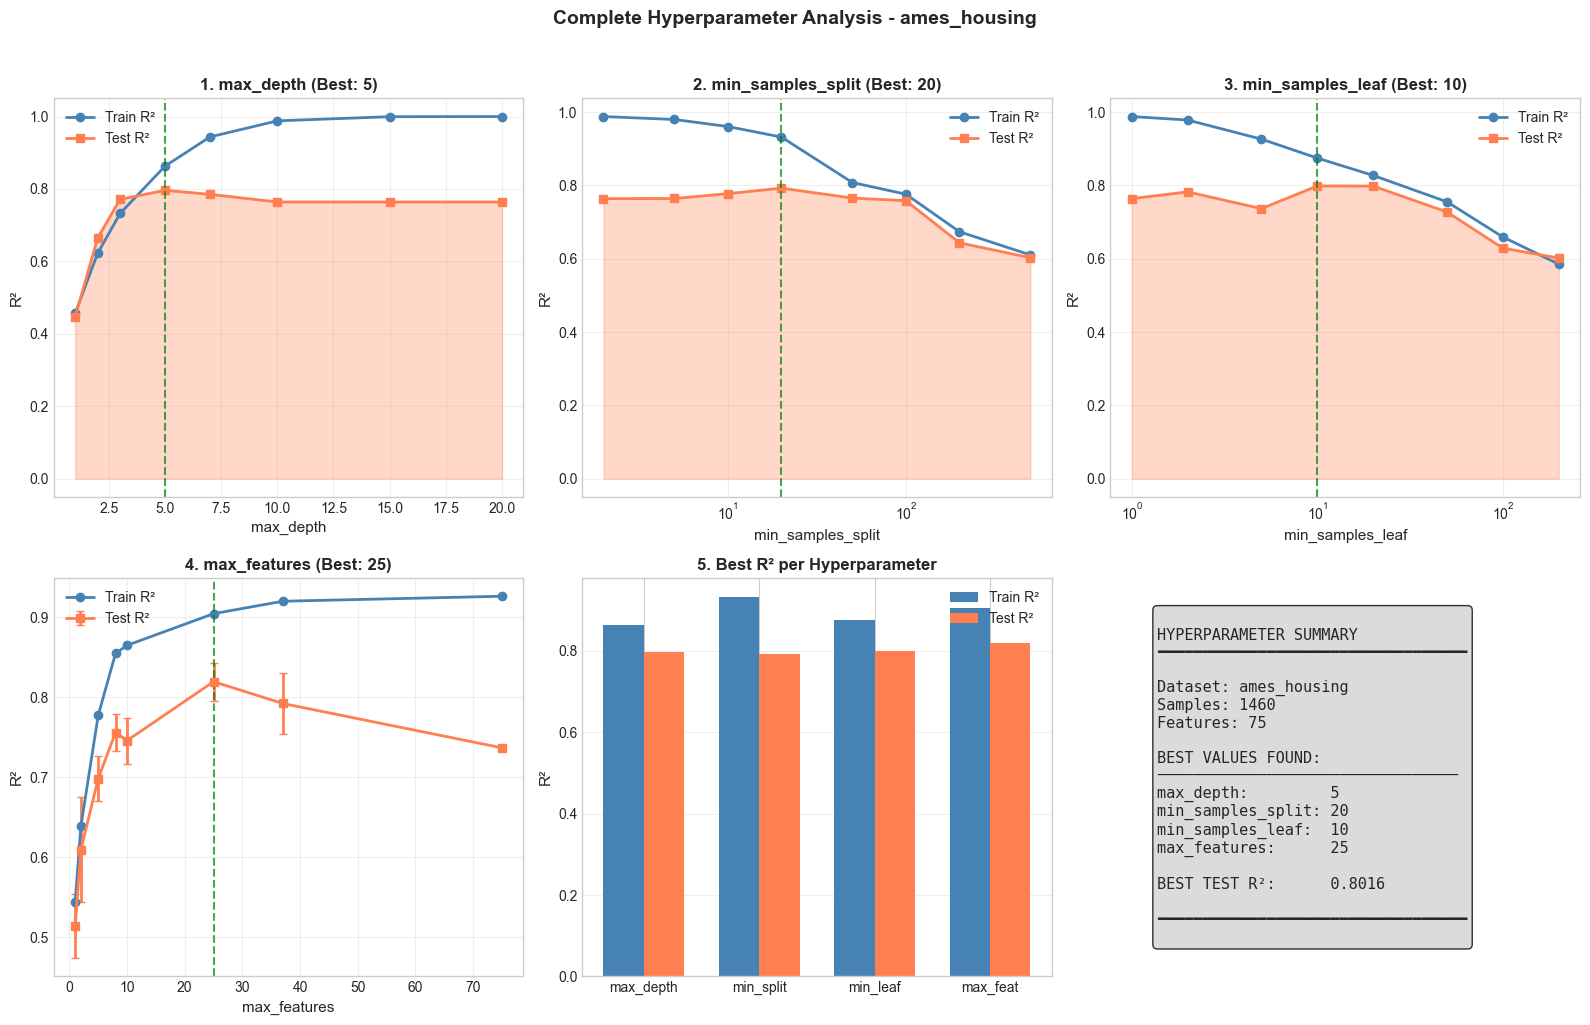

In [105]:
# Final comprehensive visualization of ALL hyperparameters
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. max_depth
ax = axes[0, 0]
ax.fill_between([r['depth'] for r in depth_results], 
                [r['test_r2'] for r in depth_results], alpha=0.3, color='coral')
ax.plot([r['depth'] for r in depth_results], [r['train_r2'] for r in depth_results], 'o-', label='Train R²', color='steelblue', linewidth=2)
ax.plot([r['depth'] for r in depth_results], [r['test_r2'] for r in depth_results], 's-', label='Test R²', color='coral', linewidth=2)
ax.axvline(best_depth_r2['depth'], color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('max_depth', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title(f'1. max_depth (Best: {best_depth_r2["depth"]})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. min_samples_split
ax = axes[0, 1]
ax.fill_between([r['min_split'] for r in split_results], 
                [r['test_r2'] for r in split_results], alpha=0.3, color='coral')
ax.plot([r['min_split'] for r in split_results], [r['train_r2'] for r in split_results], 'o-', label='Train R²', color='steelblue', linewidth=2)
ax.plot([r['min_split'] for r in split_results], [r['test_r2'] for r in split_results], 's-', label='Test R²', color='coral', linewidth=2)
ax.axvline(best_split_r2['min_split'], color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('min_samples_split', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title(f'2. min_samples_split (Best: {best_split_r2["min_split"]})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# 3. min_samples_leaf
ax = axes[0, 2]
ax.fill_between([r['min_leaf'] for r in leaf_results], 
                [r['test_r2'] for r in leaf_results], alpha=0.3, color='coral')
ax.plot([r['min_leaf'] for r in leaf_results], [r['train_r2'] for r in leaf_results], 'o-', label='Train R²', color='steelblue', linewidth=2)
ax.plot([r['min_leaf'] for r in leaf_results], [r['test_r2'] for r in leaf_results], 's-', label='Test R²', color='coral', linewidth=2)
ax.axvline(best_leaf_r2['min_leaf'], color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('min_samples_leaf', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title(f'3. min_samples_leaf (Best: {best_leaf_r2["min_leaf"]})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# 4. max_features
ax = axes[1, 0]
ax.errorbar([r['max_features'] for r in features_results], [r['test_r2'] for r in features_results], 
            yerr=[r['test_r2_std'] for r in features_results], fmt='s-', label='Test R²', color='coral', capsize=3, linewidth=2)
ax.plot([r['max_features'] for r in features_results], [r['train_r2'] for r in features_results], 'o-', label='Train R²', color='steelblue', linewidth=2)
ax.axvline(best_features_r2['max_features'], color='green', linestyle='--', alpha=0.7)
ax.set_xlabel('max_features', fontsize=11)
ax.set_ylabel('R²', fontsize=11)
ax.set_title(f'4. max_features (Best: {best_features_r2["max_features"]})', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Overfitting gap analysis
ax = axes[1, 1]
params = ['max_depth', 'min_split', 'min_leaf', 'max_feat']
best_train = [best_depth_r2['train_r2'], best_split_r2['train_r2'], best_leaf_r2['train_r2'], best_features_r2['train_r2']]
best_test = [best_depth_r2['test_r2'], best_split_r2['test_r2'], best_leaf_r2['test_r2'], best_features_r2['test_r2']]
x_pos = np.arange(len(params))
width = 0.35
ax.bar(x_pos - width/2, best_train, width, label='Train R²', color='steelblue')
ax.bar(x_pos + width/2, best_test, width, label='Test R²', color='coral')
ax.set_xticks(x_pos)
ax.set_xticklabels(params)
ax.set_ylabel('R²', fontsize=11)
ax.set_title('5. Best R² per Hyperparameter', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 6. Summary table as text
ax = axes[1, 2]
ax.axis('off')
summary_text = f"""
HYPERPARAMETER SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Dataset: {DATASET_NAME}
Samples: {X.shape[0]}
Features: {X.shape[1]}

BEST VALUES FOUND:
─────────────────────────────────
max_depth:         {best_depth_r2['depth']}
min_samples_split: {best_split_r2['min_split']}
min_samples_leaf:  {best_leaf_r2['min_leaf']}
max_features:      {best_features_r2['max_features']}

BEST TEST R²:      {best_r2:.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=11, 
        verticalalignment='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle(f'Complete Hyperparameter Analysis - {DATASET_NAME}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_complete_hyperparameter_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


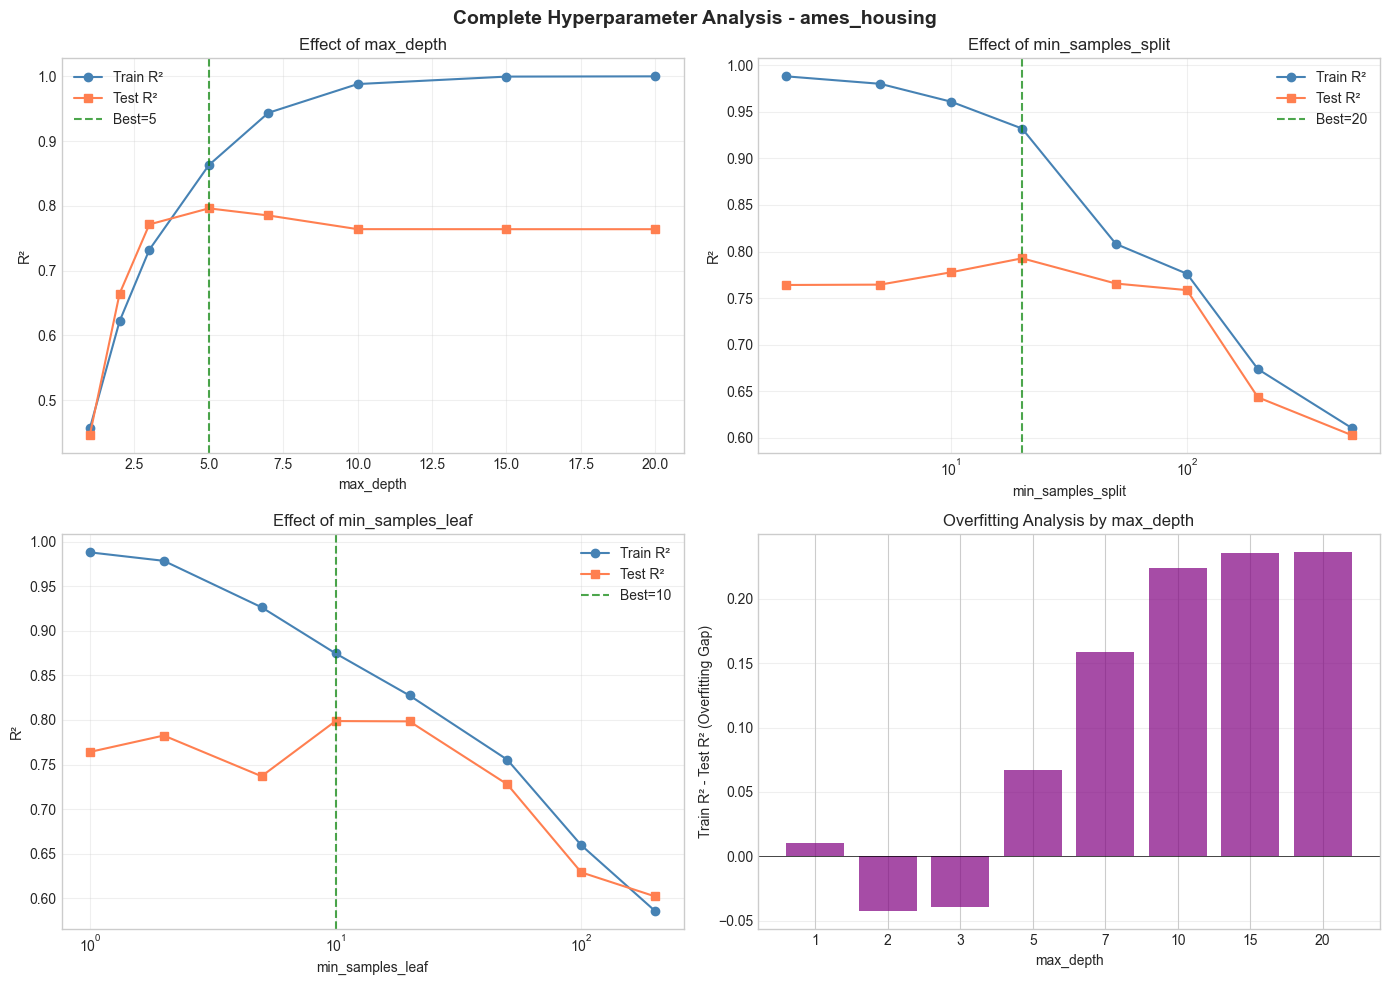

In [106]:
# Combined visualization of all hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. max_depth
ax = axes[0, 0]
ax.plot([r['depth'] for r in depth_results], [r['train_r2'] for r in depth_results], 'o-', label='Train R²', color='steelblue')
ax.plot([r['depth'] for r in depth_results], [r['test_r2'] for r in depth_results], 's-', label='Test R²', color='coral')
ax.axvline(best_depth_r2['depth'], color='green', linestyle='--', alpha=0.7, label=f'Best={best_depth_r2["depth"]}')
ax.set_xlabel('max_depth')
ax.set_ylabel('R²')
ax.set_title('Effect of max_depth')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. min_samples_split
ax = axes[0, 1]
ax.plot([r['min_split'] for r in split_results], [r['train_r2'] for r in split_results], 'o-', label='Train R²', color='steelblue')
ax.plot([r['min_split'] for r in split_results], [r['test_r2'] for r in split_results], 's-', label='Test R²', color='coral')
ax.axvline(best_split_r2['min_split'], color='green', linestyle='--', alpha=0.7, label=f'Best={best_split_r2["min_split"]}')
ax.set_xlabel('min_samples_split')
ax.set_ylabel('R²')
ax.set_title('Effect of min_samples_split')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# 3. min_samples_leaf
ax = axes[1, 0]
ax.plot([r['min_leaf'] for r in leaf_results], [r['train_r2'] for r in leaf_results], 'o-', label='Train R²', color='steelblue')
ax.plot([r['min_leaf'] for r in leaf_results], [r['test_r2'] for r in leaf_results], 's-', label='Test R²', color='coral')
ax.axvline(best_leaf_r2['min_leaf'], color='green', linestyle='--', alpha=0.7, label=f'Best={best_leaf_r2["min_leaf"]}')
ax.set_xlabel('min_samples_leaf')
ax.set_ylabel('R²')
ax.set_title('Effect of min_samples_leaf')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# 4. Overfitting analysis (train vs test gap)
ax = axes[1, 1]
gaps = [r['train_r2'] - r['test_r2'] for r in depth_results]
ax.bar([str(r['depth']) for r in depth_results], gaps, color='purple', alpha=0.7)
ax.set_xlabel('max_depth')
ax.set_ylabel('Train R² - Test R² (Overfitting Gap)')
ax.set_title('Overfitting Analysis by max_depth')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Complete Hyperparameter Analysis - {DATASET_NAME}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_hyperparameter_summary.png', dpi=150, bbox_inches='tight')
plt.show()


---
## 6. Visualizations

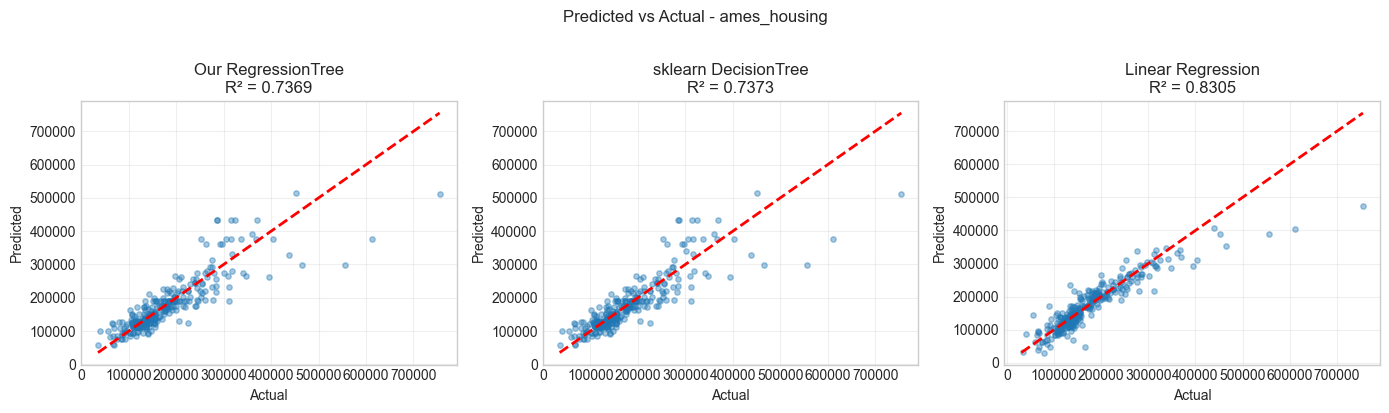

In [107]:
# Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, res) in zip(axes, all_results.items()):
    ax.scatter(y_test, res['y_test_pred'], alpha=0.4, s=15)
    lims = [min(y_test.min(), res['y_test_pred'].min()), max(y_test.max(), res['y_test_pred'].max())]
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f"{name}\nR² = {res['test_r2']:.4f}")
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Predicted vs Actual - {DATASET_NAME}', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_predictions.png', dpi=150)
plt.show()

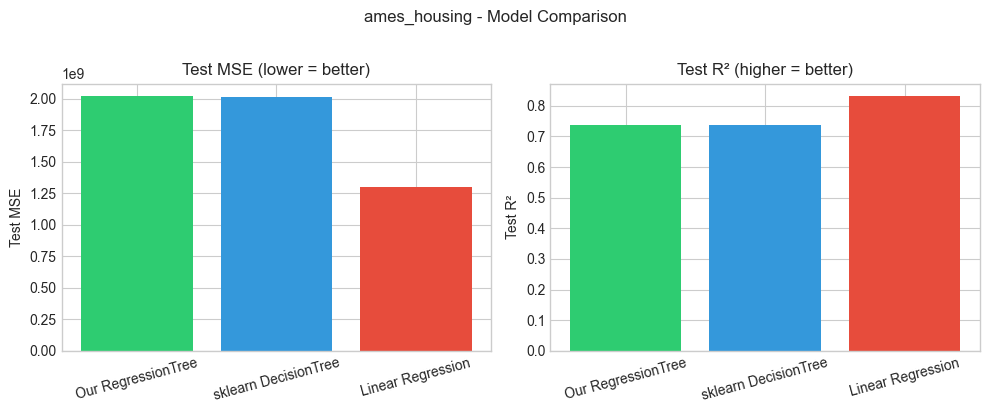

In [108]:
# Model comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

models = list(all_results.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c']

axes[0].bar(models, [all_results[m]['test_mse'] for m in models], color=colors)
axes[0].set_ylabel('Test MSE')
axes[0].set_title('Test MSE (lower = better)')
axes[0].tick_params(axis='x', rotation=15)

axes[1].bar(models, [all_results[m]['test_r2'] for m in models], color=colors)
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² (higher = better)')
axes[1].tick_params(axis='x', rotation=15)

plt.suptitle(f'{DATASET_NAME} - Model Comparison', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_comparison.png', dpi=150)
plt.show()

---
## 7. Tree Structure Analysis

In [109]:
def count_nodes(node):
    if node is None: return 0
    if node.is_leaf(): return 1
    return 1 + count_nodes(node.left) + count_nodes(node.right)

def count_leaves(node):
    if node is None: return 0
    if node.is_leaf(): return 1
    return count_leaves(node.left) + count_leaves(node.right)

def get_depth(node, d=0):
    if node is None or node.is_leaf(): return d
    return max(get_depth(node.left, d+1), get_depth(node.right, d+1))

def get_feature_usage(node, counts=None):
    if counts is None: counts = {}
    if node is None or node.is_leaf(): return counts
    counts[node.feature_idx] = counts.get(node.feature_idx, 0) + 1
    get_feature_usage(node.left, counts)
    get_feature_usage(node.right, counts)
    return counts

print("Tree Structure")
print("="*40)
print(f"  Total nodes: {count_nodes(our_tree.root)}")
print(f"  Leaf nodes:  {count_leaves(our_tree.root)}")
print(f"  Max depth:   {get_depth(our_tree.root)}")

usage = get_feature_usage(our_tree.root)
print(f"\nFeature Usage:")
for idx, cnt in sorted(usage.items(), key=lambda x: -x[1]):
    name = feature_names[idx] if idx < len(feature_names) else f'Feature {idx}'
    print(f"  {name}: {cnt} splits")

Tree Structure
  Total nodes: 295
  Leaf nodes:  148
  Max depth:   10

Feature Usage:
  GrLivArea: 14 splits
  LotArea: 10 splits
  TotalBsmtSF: 9 splits
  GarageArea: 8 splits
  OpenPorchSF: 8 splits
  1stFlrSF: 8 splits
  OverallQual: 7 splits
  YearBuilt: 7 splits
  YearRemodAdd: 6 splits
  LotFrontage: 5 splits
  Neighborhood: 5 splits
  BsmtFinType1: 4 splits
  GarageYrBlt: 4 splits
  OverallCond: 4 splits
  GarageType: 3 splits
  MoSold: 3 splits
  GarageCars: 3 splits
  Exterior1st: 3 splits
  MasVnrArea: 3 splits
  BsmtFinSF1: 3 splits
  YrSold: 3 splits
  CentralAir: 2 splits
  BsmtUnfSF: 2 splits
  Fireplaces: 2 splits
  FullBath: 2 splits
  MSSubClass: 2 splits
  KitchenQual: 2 splits
  WoodDeckSF: 2 splits
  PavedDrive: 1 splits
  EnclosedPorch: 1 splits
  Foundation: 1 splits
  BsmtQual: 1 splits
  HeatingQC: 1 splits
  BedroomAbvGr: 1 splits
  FireplaceQu: 1 splits
  Functional: 1 splits
  HalfBath: 1 splits
  Exterior2nd: 1 splits
  BsmtExposure: 1 splits
  MasVnrType: 

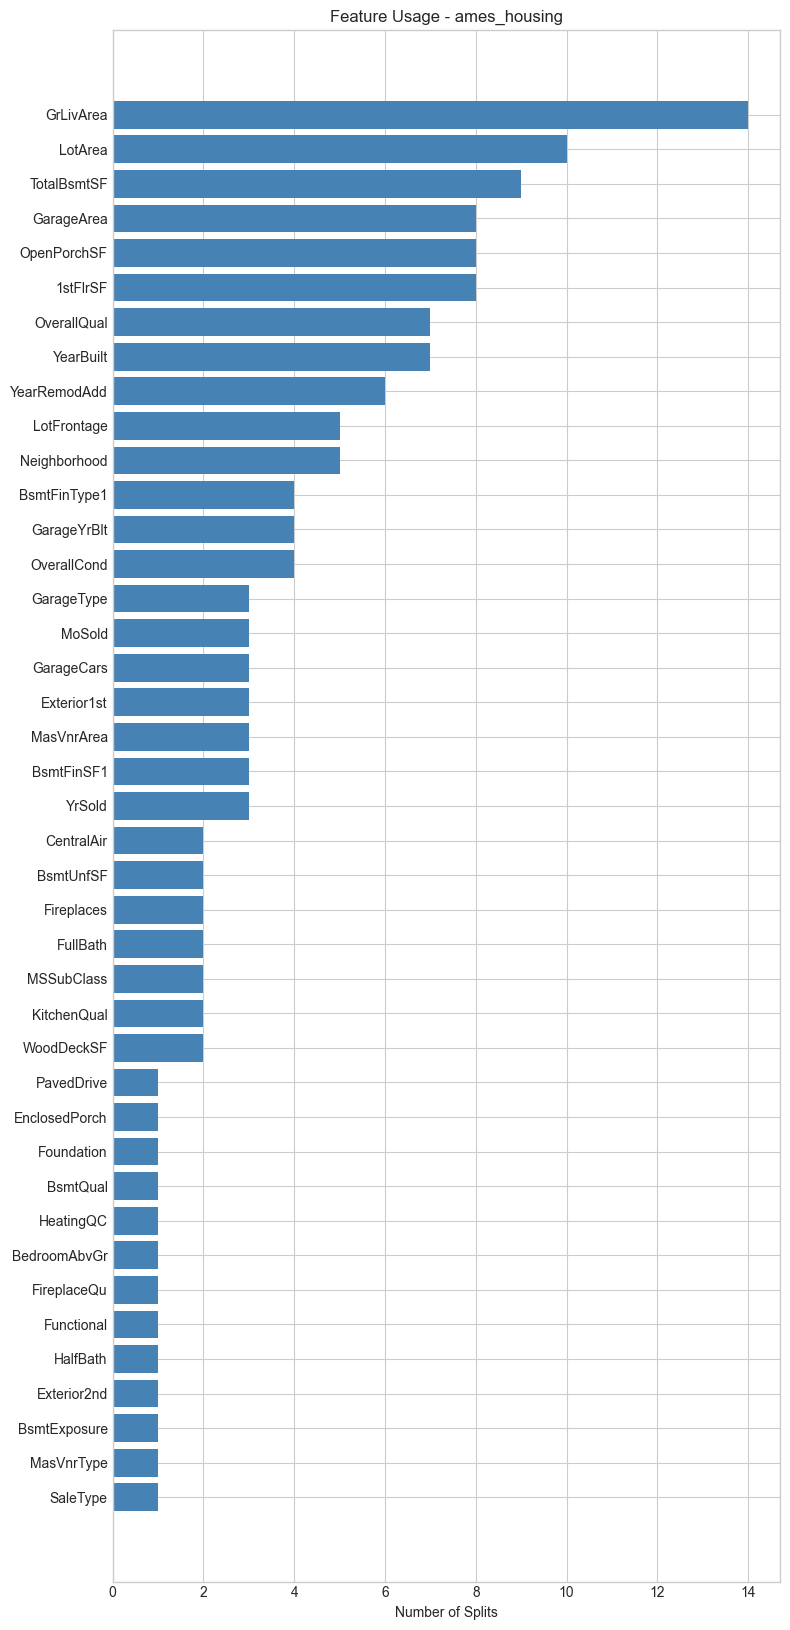

In [110]:
# Feature usage plot
if usage:
    sorted_usage = sorted(usage.items(), key=lambda x: -x[1])
    names = [feature_names[i] if i < len(feature_names) else f'F{i}' for i, _ in sorted_usage]
    counts = [c for _, c in sorted_usage]
    
    plt.figure(figsize=(8, max(4, len(names)*0.4)))
    plt.barh(range(len(names)), counts, color='steelblue')
    plt.yticks(range(len(names)), names)
    plt.xlabel('Number of Splits')
    plt.title(f'Feature Usage - {DATASET_NAME}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / f'{DATASET_NAME}_feature_usage.png', dpi=150)
    plt.show()

---
## 8. Save Results

In [111]:
# Save results to CSV
results_df = pd.DataFrame([
    {'Model': 'Our RegressionTree', 'Test_MSE': our_results['test_mse'], 
     'Test_R2': our_results['test_r2'], 'Train_Time': our_results['train_time'],
     'CV_MSE_Mean': our_cv['mse_mean'], 'CV_R2_Mean': our_cv['r2_mean']},
    {'Model': 'sklearn DecisionTree', 'Test_MSE': sklearn_results['test_mse'], 
     'Test_R2': sklearn_results['test_r2'], 'Train_Time': sklearn_results['train_time'],
     'CV_MSE_Mean': sklearn_cv['mse_mean'], 'CV_R2_Mean': sklearn_cv['r2_mean']},
    {'Model': 'Linear Regression', 'Test_MSE': linear_results['test_mse'], 
     'Test_R2': linear_results['test_r2'], 'Train_Time': linear_results['train_time'],
     'CV_MSE_Mean': linear_cv['mse_mean'], 'CV_R2_Mean': linear_cv['r2_mean']}
])

results_df.to_csv(METRICS_DIR / f'{DATASET_NAME}_results.csv', index=False)
print(f"Results saved to: {METRICS_DIR / f'{DATASET_NAME}_results.csv'}")
results_df

Results saved to: ../results/metrics/ames_housing_results.csv


,Model,Test_MSE,Test_R2,Train_Time,CV_MSE_Mean,CV_R2_Mean
0,Our RegressionTree,2.018365e+09,0.736861,1.608952,1.791252e+09,0.710990
1,sklearn DecisionTree,2.015047e+09,0.737293,0.019263,1.790202e+09,0.711143
2,Linear Regression,1.299879e+09,0.830532,0.029670,1.464060e+09,0.757777
